#### Proof of concept

Идея:

* Создадим разные секретные модели. Даже не обязательно, чтобы они показывали высокую точность.
* Создадим одну модель для остатков.
* Убедимся в том, что локлаьные модели для остатков повышают скор соответсвующих секретных моделей.
* Убедимся в том, что модель для остатоков получает буст от федеративного обучения.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import Markdown as md
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings

from tsfresh.feature_extraction import settings
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import (
    impute,
    make_forecasting_frame,
    roll_time_series,
)
from tsfresh.feature_extraction import (
    ComprehensiveFCParameters,
    MinimalFCParameters,
    EfficientFCParameters,
    settings,
)
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    max_error as ME,
    mean_absolute_error as MAE,
    mean_absolute_percentage_error as MAPE,
)

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


df = pd.read_csv("Datasets/all_stocks_5yr.csv")
df["date"] = pd.to_datetime(df["date"])

# https://www.kaggle.com/code/avikumart/timeseries-stock-price-analysis-forecasting/input
df = df[df.Name == "AAPL"]

In [2]:
# df.drop(columns=['date','Name']).to_csv("Datasets/apple.csv", index=False)
apl = df.drop(columns=['Name'])
apl.to_csv("Datasets/apple.csv", index=False)
apl_orig = apl

In [3]:
# apl

In [4]:
y = df.volume

In [5]:
# y_true = df_test.volume
# y_pred = df_test.holt

In [6]:
DAILY = None
def return_metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    c = len(y_true) - 1
    cur = y_true[:c]
    next = y_true.shift(-1)[:c]
    daily_return = (next - cur) * np.sign(y_pred[:-1].values - cur.values)
    global DAILY
    DAILY = daily_return
    # print(daily_return)
    return sum(daily_return)#, daily_return


def wape(y_true,y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

def mape(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.volume, name="volume"))
fig.add_trace(go.Scatter(x=df.date, y=df.close*10**6, name="close"))
# fig.update_layout(    xaxis_title="№ month")

In [8]:
d = datetime.date(2015, 9, 27)
test_finish = datetime.date(2017, 3, 27)
df_train = df[df.date.dt.date < d]
df_test = df[(df.date.dt.date >= d) & (df.date.dt.date < test_finish)]

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.date, y=df_train.volume, name="Train"))
fig.add_trace(go.Scatter(x=df_test.date, y=df_test.volume, name="Test"))

In [10]:
df["next"] = df.volume.shift(-1)
df["prev"] = df.volume.shift(1)

In [11]:
from sklearn.metrics import mean_absolute_error as mae

### Prev day

In [12]:
mape(df.loc[df_test.index].volume, df.loc[df_test.index].prev),

(0.2702159524632046,)

In [13]:
df["ema_0.05"] = df.volume.ewm(alpha=0.05).mean()
df["ema_0.1"] = df.volume.ewm(alpha=0.1).mean()
df_test['ema_0.1'] = df["ema_0.1"].loc[df_test.index]

In [14]:
# (
#     mae(df.loc[df_test.index].volume, df.loc[df_test.index]["ema_0.05"]),
#     return_metric(df.loc[df_test.index].volume,
#                   df.loc[df_test.index]["ema_0.05"]),
# )

In [15]:
# (
#     mae(df.loc[df_test.index].volume, df.loc[df_test.index]["ema_0.1"]),
#     return_metric(df.loc[df_test.index].volume,
#                   df.loc[df_test.index]["ema_0.1"]),
# )

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.date, y=df_train.volume, name="Train"))
fig.add_trace(go.Scatter(x=df_test.date, y=df_test.volume, name="Test"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df.loc[df_test.index].prev, name="prev day"))
fig.add_trace(
    go.Scatter(x=df_test.date,
               y=df.loc[df_test.index]["ema_0.1"], name="ema 0.1")
)

### Holt

In [17]:
# def seq_fit_predict():
#     pred = []
#     for i in range(len(df_train), len(df_train) + len(df_test)):
#         fit3 = Holt(
#             df.volume.iloc[:i], damped_trend=True, initialization_method="estimated"
#         ).fit(smoothing_level=0.8, smoothing_trend=0.2)
#         fcast3 = fit3.forecast(1)
#         pred.append(fcast3.iloc[-1])
#     return pred


# holt_pred = seq_fit_predict()
# df_test["holt"] = holt_pred

In [18]:
# (mae(df_test.volume, df_test.holt), return_metric(df_test.volume, df_test.holt))

In [19]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_train.date, y=df_train.volume, name="Train"))
# fig.add_trace(go.Scatter(x=df_test.date, y=df_test.volume, name="Test"))
# fig.add_trace(go.Scatter(x=df_test.date, y=df.loc[df_test.index].prev, name="prev day"))
# fig.add_trace(
#     go.Scatter(x=df_test.date, y=df.loc[df_test.index]["ema_0.1"], name="ema 0.1")
# )

In [20]:
t = df.loc[df_train.index]  # .drop(['date', 'Name'], axis=1)
cols = ['open', 'high', 'low', 'volume', 'close']
# cols = ['volume']
X = t[cols]
y = t.next

In [21]:
# from sklearn import svm
# regr = svm.SVR()
# regr.fit(X, y)
# df_test['svm'] = regr.predict(df_test[cols])
# return_metric(df_test.volume, df_test.svm)
# from sklearn.linear_model import BayesianRidge
# regr = BayesianRidge()
# regr.fit(X, y)
# df_test['bayes'] = regr.predict(df_test[cols])
# # return_metric(df_test.volume, df_test.bayes)
# mape(df_test.volume, df_test.bayes)

In [22]:
shifts = pd.concat([df.volume]+[df.volume.shift(i) for i in range(1,6)], axis=1,
          keys = ['volume']+[f'shift{i}' for i in range(1, 6)])

In [23]:
# shifts

In [24]:
from sklearn.linear_model import LinearRegression
lin_regr = LinearRegression()
shift_x = shifts.drop('volume', axis=1)
shift_y = shifts['volume']
lin_regr.fit(shift_x.loc[df_train.index[6:]], shift_y.loc[df_train.index[6:]])
df_test['linear'] = lin_regr.predict(shift_x.loc[df_test.index])
return_metric(df_test.volume, df_test.linear)
mape(df_test.volume, df_test.linear)


0.3827281182798035

In [25]:
lin_regr.coef_

array([0.5257614 , 0.06420127, 0.00631824, 0.12442698, 0.07367404])

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.date, y=df_train.volume, name="Train"))
fig.add_trace(go.Scatter(x=df_test.date, y=df_test.volume, name="Test"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df.loc[df_test.index].prev, name="prev day"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df.loc[df_test.index]["ema_0.1"], name="ema 0.1"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df_test.linear, name="linear"))

In [27]:
# TODO standartise

In [31]:
# r_holt = df_test.volume - df_test.holt
r_linear = df_test.volume - df_test.linear
# r_bayes = df_test.volume - df_test.bayes
r_ema = df_test.volume - df_test['ema_0.1']

In [32]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_test.date, y=r_holt, name="Holt"))
fig.add_trace(go.Scatter(x=df_test.date, y=r_linear, name="linear"))
# fig.add_trace(go.Scatter(x=df_test.date, y=r_bayes, name="bayes"))
fig.add_trace(go.Scatter(x=df_test.date, y=r_ema, name="ema"))

In [33]:
# ! pip install fedot

In [34]:
# from fedot.api.main import Fedot
# from fedot.core.data.data import InputData
# from fedot.core.data.data_split import train_test_data_setup
# from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# # specify the task and the forecast length (required depth of forecast)
# task = Task(TaskTypesEnum.ts_forecasting,
#             TsForecastingParams(forecast_length=10))

# # load data from csv
# train_input = InputData.from_csv_time_series(task=task,
#                                             #  file_path='time_series.csv',
#                                              file_path="Datasets/apple.csv",
#                                              delimiter=',',
#                                              target_column='volume')
# # split data for train and test
# train_data, test_data = train_test_data_setup(train_input)

# # init model for the time-series forecasting
# model = Fedot(problem='ts_forecasting', task_params=task.task_params)

# # run AutoML model design
# pipeline = model.fit(train_data)
# # plot obtained pipeline
# pipeline.show()

# # use model to obtain out-of-sample forecast with one step
# forecast = model.forecast(test_data)
# print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=test_data.target))

# # plot forecasting result
# model.plot_prediction()

In [35]:
# ! pip install autots

In [36]:
# # also load: _hourly, _monthly, _weekly, _yearly, or _live_daily
# from autots import AutoTS, load_daily

# # sample datasets can be used in either of the long or wide import shapes
# long = False
# df = load_daily(long=long)

# model = AutoTS(
#     forecast_length=21,
#     frequency='infer',
#     prediction_interval=0.9,
#     ensemble='auto',
#     model_list="fast",  # "superfast", "default", "fast_parallel"
#     transformer_list="fast",  # "superfast",
#     drop_most_recent=1,
#     max_generations=4,
#     num_validations=2,
#     validation_method="backwards"
# )
# model = model.fit(
#     df,
#     date_col='datetime' if long else None,
#     value_col='value' if long else None,
#     id_col='series_id' if long else None,
# )

# prediction = model.predict()
# # plot a sample
# prediction.plot(model.df_wide_numeric,
#                 series=model.df_wide_numeric.columns[0],
#                 start_date="2019-01-01")
# # Print the details of the best model
# print(model)

# # point forecasts dataframe
# forecasts_df = prediction.forecast
# # upper and lower forecasts
# forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

# # accuracy of all tried model results
# model_results = model.results()
# # and aggregated from cross validation
# validation_results = model.results("validation")

#### Auto

In [37]:
apl_vol = apl.rename(columns={'date':'datetime'})[['datetime','volume']]
apl_vol['series_id'] ='vol'
apl_vol.head(2)

,datetime,volume,series_id
1259,2013-02-08,158168416,vol
1260,2013-02-11,129029425,vol


In [38]:
apl_vol.shape

(1259, 3)

In [ ]:
# from autots.datasets import load_daily

# df_long = load_daily(long=True)

# # df_long
# model = AutoTS(forecast_length=1, frequency='infer', 
#                ensemble='simple', drop_data_older_than_periods=200)
# # model = model.fit(data, date_col='Date', value_col='volume', id_col=None)

In [ ]:

# df_long = load_daily(long=True)

from autots import AutoTS

# model = AutoTS(
#     forecast_length=1,
#     frequency='infer',
#     ensemble='simple',
#     max_generations=5,
#     num_validations=2,
# )
model = AutoTS(forecast_length=100, frequency='infer', 
               ensemble='simple', 
            #    drop_data_older_than_periods=200,
               model_list="superfast",model_interrupt=True)

model = model.fit(apl_vol.loc[df_train.index],
                   date_col='datetime', value_col='volume', id_col='series_id')

# Print the description of the best model
# print(model)

Data frequency is: B, used frequency is: B
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model GLS in generation 0 of 10
Model Number: 5 with model GLS in generation 0 of 10
Model Number: 6 with model LastValueNaive in generation 0 of 10
Model Number: 7 with model LastValueNaive in generation 0 of 10
Model Number: 8 with model LastValueNaive in generation 0 of 10
Model Number: 9 with model LastValueNaive in generation 0 of 10
Model Number: 10 with model SeasonalNaive in generation 0 of 10
Model Number: 11 with model SeasonalNaive in generation 0 of 10
Model Number: 12 with model SeasonalNaive in generation 0 of 10
Model Number: 13 with model ConstantNaive in generation 0 of 10
Model Number: 14 with model SeasonalNaive in generation 0 of 10
Model Number: 15 with model SeasonalNaive in generation 0 of 10
Model Numb

In [ ]:
model.best_model_name

'Ensemble'

In [ ]:
df_test = df_test.iloc[:100]
prediction = model.predict()
pr = prediction.forecast

In [ ]:
df_test['auto'] = pr.values

In [ ]:
mape(df_test.volume.values, pr.values)

0.35152137247384413

In [39]:
mape(df_test.volume.values, df_test.linear)


0.3827281182798035

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.date, y=df_train.volume, name="Train"))
fig.add_trace(go.Scatter(x=df_test.date, y=df_test.volume, name="Test"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df.loc[df_test.index].prev, name="prev day"))
fig.add_trace(go.Scatter(x=df_test.date,
              y=df.loc[df_test.index]["ema_0.1"], name="ema 0.1"))
fig.add_trace(go.Scatter(x=df_test.date,              y=df_test.linear, name="linear"))
fig.add_trace(go.Scatter(x=df_test.date,              y=df_test.auto, name="auto"))

AttributeError: 'DataFrame' object has no attribute 'auto'

### TSFresh

In [41]:
apl = apl_orig.copy()
apl.set_index('date', inplace=True)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

scaler = StandardScaler()
ct = make_column_transformer(
    (StandardScaler(), list(apl.columns)),
)

apl.loc[:, :] = ct.fit_transform(apl)
# ts = apl.diff().dropna()
ts = apl.dropna()

In [43]:
extraction_settings = EfficientFCParameters()
# extraction_settings = ComprehensiveFCParameters()
del extraction_settings["friedrich_coefficients"]
del extraction_settings["max_langevin_fixed_point"]
# extraction_settings = MinimalFCParameters()

horizon = 1


In [44]:
dfts = ts.copy()
dfts["id"] = 'volume'
dfts.reset_index(inplace=True)
df_rolled = roll_time_series(
    dfts, column_id="id", column_sort="date", max_timeshift=20, min_timeshift=5
)
# каждый момент времени описываем окном длины не больше 20, окна длины меньше чем 5 отбрасываем
name = 'volume'
X = extract_features(
    df_rolled,
    column_id="id",
    column_sort="date",
    column_value=name,
    impute_function=impute,
    show_warnings=False,
    default_fc_parameters=extraction_settings,
)
X.set_index(X.index.map(lambda x: x[1]), inplace=True)
X[name] = ts.volume  # добавялем оригинальный ряд
X["y"] = X[name].shift(-horizon)

Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


In [45]:
df = X.dropna()
y = df.y
df.drop("y", axis=1, inplace=True)
X = df
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, shuffle=False)

X_train_selected = select_features(X_train, y_train)
best_features=X_train_selected.columns
X_train = X_train_selected
X_test = X_test[best_features]

In [46]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(silent=True).fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [47]:
y_pred_dumb = y_test.shift(1)
MAE(y_test[1:], y_pred_dumb[1:]),MAE(y_test, y_pred)

(0.2512812143934323, 0.5907895489577585)

In [48]:
fig = go.Figure()
fig.update_layout(title_text=f"CatBoost & tsfresh. MAE={MAE(y_test, y_pred):.4f}")
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, name="Test"))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred, name="Predicted"))

<AxesSubplot: >

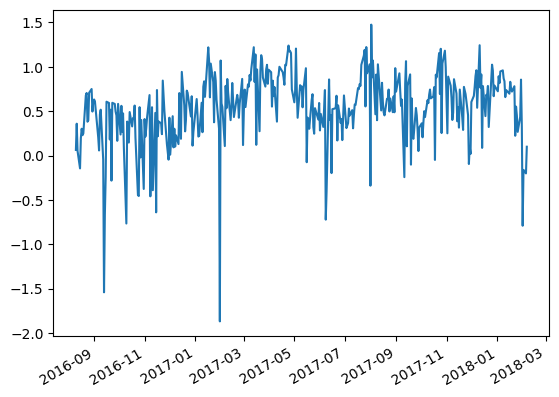

In [53]:
r = y_pred - y_test
r.plot()

<AxesSubplot: >

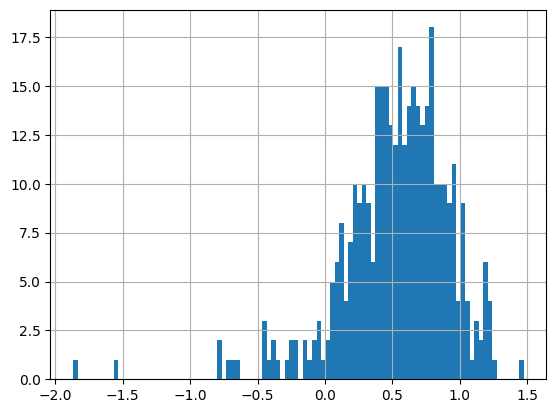

In [51]:
r.hist(bins=100)

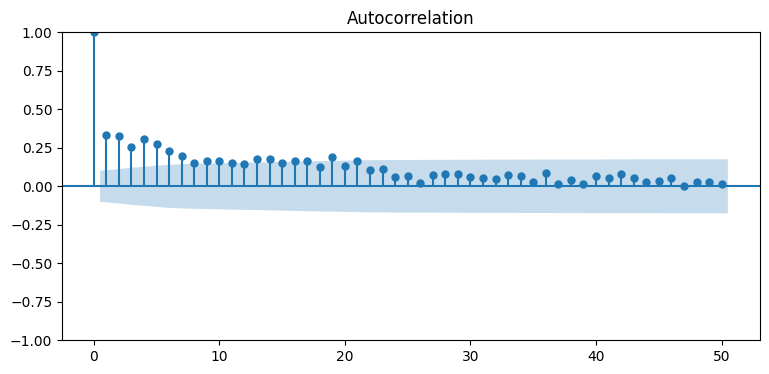

In [ ]:
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 9, 4
# ACF function up to 50 lags
fig = plot_acf(r, lags=50)

In [52]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(r)

print(f"ADF Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -4.45702549944812
p-value: 0.0002349537251926172
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
